In [16]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
import seaborn as sns
import json
import codecs
from pathlib import Path
from collections import defaultdict

while Path.cwd().name != 'dexperts':
    %cd ..  

In [17]:
def read_sentiment_results(models_dict, max_gens=None):
    res = {}
    for model in tqdm(models_dict):
        df = pd.read_json(models_dict[model], lines=True)[:max_gens]
        sentiment_labels = df.generations.apply(lambda x: [y['label'] for y in x])
        positive_proportion = sentiment_labels.apply(lambda x: np.sum([1 for y in x if y == 'POSITIVE'])/len(x))
        res[model] = {
            'positive_proportion': positive_proportion.mean()
        }
        # read automatic evaluation
        with open(Path(os.path.dirname(models_dict[model])) / 'eval_results.txt', 'r') as fo:
            for i, line in enumerate(fo):
                if i < 3:
                    dist_n = float(line.rstrip().replace(f'dist-{i+1} = ', ''))
                    res[model][f'dist-{i+1}'] = dist_n
                elif i == 3:
                    ppl = float(line.replace('perplexity = ', ''))
                    res[model]['perplexity'] = ppl
    return res

In [18]:
def weighted_average(neutral_prompts_res, adversarial_prompts_res, key):
    """
    return weighted average of dist-n or perplexity value across neural prompts (5k) and adversarial prompts (2.5k)
    """
    return np.average([neutral_prompts_res[model][key], adversarial_prompts_res[model][key]], weights=[2,1])

## positive steering

In [19]:
# results corresponding to the top half of Table 3

NEUTRAL_DIR = Path('generations/sentiment/neutral_prompts/')
NEG_DIR = Path('generations/sentiment/negative_prompts/')

models = {
    'GPT-2': {
        'neutral_path': NEUTRAL_DIR / 'gpt2/prompted_gens_gpt2.jsonl',
        'neg_path': NEG_DIR / 'gpt2/prompted_gens_gpt2.jsonl',
    },
    'PPLM': {
        'neutral_path': NEUTRAL_DIR / 'pplm/positive/prompted_gens_pplm.jsonl',
        'neg_path': NEG_DIR / 'pplm/prompted_gens_pplm.jsonl'
    },
    'DAPT': {
        'neutral_path': NEUTRAL_DIR / 'dapt/positive/prompted_gens_gpt2.jsonl',
        'neg_path': NEG_DIR / 'dapt/prompted_gens_gpt2.jsonl',
    },
    'GeDi': {
        'neutral_path': NEUTRAL_DIR / 'gedi/positive/prompted_gens_gedi.jsonl',
        'neg_path': NEG_DIR / 'gedi/prompted_gens_gedi.jsonl'
    },
    'CTRL': {
        'neutral_path': NEUTRAL_DIR / 'ctrl/positive/prompted_gens_ctrl.jsonl',
        'neg_path': NEG_DIR / 'ctrl/prompted_gens_ctrl.jsonl'
    },
    'Expert': {
        'neutral_path': NEUTRAL_DIR / 'expert/positive/prompted_gens_gpt2.jsonl',
        'neg_path': NEG_DIR / 'expert/prompted_gens_gpt2.jsonl',
    },
    'DExperts (anti-only)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts_anti-only/a-2.0/prompted_gens_dexperts.jsonl',
        'neg_path': NEG_DIR / 'dexperts_anti-only/a-2.0/prompted_gens_dexperts.jsonl',
    },
    'DExperts (small)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/small_experts/positive/prompted_gens_dexperts.jsonl',
        'neg_path': NEG_DIR / 'dexperts/small_experts/prompted_gens_dexperts.jsonl'
    },
    'DExperts (medium)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/medium_experts/positive/prompted_gens_dexperts.jsonl',
        'neg_path': NEG_DIR / 'dexperts/small_experts/prompted_gens_dexperts.jsonl'
    },
    'DExperts (large)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/large_experts/positive/prompted_gens_dexperts.jsonl',
        'neg_path': NEG_DIR / 'dexperts/small_experts/prompted_gens_dexperts.jsonl'
    },
}

In [20]:
# read sentiment control results
neutral_prompts_res = read_sentiment_results({m: p['neutral_path'] for m,p in models.items()})
neg_prompts_res = read_sentiment_results({m: p['neg_path'] for m,p in models.items()})

100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


In [21]:
positive_steering_res = {}
assert set(neutral_prompts_res.keys()) == set(neg_prompts_res.keys())
for model in neutral_prompts_res.keys():
    positive_steering_res[model] = {
        'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'neg_prompts': neg_prompts_res[model]['positive_proportion']*100,
        'dist-1': weighted_average(neutral_prompts_res, neg_prompts_res, 'dist-1'),
        'dist-2': weighted_average(neutral_prompts_res, neg_prompts_res, 'dist-2'),
        'dist-3': weighted_average(neutral_prompts_res, neg_prompts_res, 'dist-3'),
        'perplexity': weighted_average(neutral_prompts_res, neg_prompts_res, 'perplexity'),
    }

In [22]:
pd.DataFrame(positive_steering_res).transpose().sort_values(by='neutral_prompts', ascending=True).round(2)

,neutral_prompts,neg_prompts,dist-1,dist-2,dist-3,perplexity
GPT-2,50.02,0.00,0.58,0.84,0.84,29.28
PPLM,52.69,8.72,0.61,0.86,0.85,142.12
DExperts (anti-only),60.72,4.43,0.65,0.81,0.78,46.01
CTRL,61.81,18.88,0.51,0.83,0.86,43.79
DAPT,77.24,14.17,0.56,0.83,0.84,30.52
Expert,79.83,43.80,0.59,0.85,0.85,64.32
GeDi,86.01,26.80,0.57,0.80,0.79,58.41
DExperts (medium),94.31,31.64,0.55,0.83,0.83,43.19
DExperts (large),94.46,31.64,0.56,0.83,0.83,45.83
DExperts (small),94.57,31.64,0.56,0.83,0.84,42.08


## negative steering

In [23]:
# results corresponding to the bottom  half of Table 3

NEUTRAL_DIR = Path('generations/sentiment/neutral_prompts/')
POS_DIR = Path('generations/sentiment/positive_prompts/')

models = {
    'GPT-2': {
        'neutral_path': NEUTRAL_DIR / 'gpt2/prompted_gens_gpt2.jsonl',
        'pos_path': POS_DIR / 'gpt2/prompted_gens_gpt2.jsonl',
    },
    'PPLM': {
        'neutral_path': NEUTRAL_DIR / 'pplm/negative/prompted_gens_pplm.jsonl',
        'pos_path': POS_DIR / 'pplm/prompted_gens_pplm.jsonl'
    },
    'DAPT': {
        'neutral_path': NEUTRAL_DIR / 'dapt/negative/prompted_gens_gpt2.jsonl',
        'pos_path': POS_DIR / 'dapt/prompted_gens_gpt2.jsonl',
    },
    'GeDi': {
        'neutral_path': NEUTRAL_DIR / 'gedi/negative/prompted_gens_gedi.jsonl',
        'pos_path': POS_DIR / 'gedi/prompted_gens_gedi.jsonl'
    },
    'CTRL': {
        'neutral_path': NEUTRAL_DIR / 'ctrl/negative/prompted_gens_ctrl.jsonl',
        'pos_path': POS_DIR / 'ctrl/prompted_gens_ctrl.jsonl'
    },
    'Expert': {
        'neutral_path': NEUTRAL_DIR / 'expert/negative/prompted_gens_gpt2.jsonl',
        'pos_path': POS_DIR / 'expert/prompted_gens_gpt2.jsonl',
    },
    'DExperts (anti-only)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts_anti-only/a--2.0/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'dexperts_anti-only/a--2.0/prompted_gens_dexperts.jsonl',
    },
    'DExperts (large)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/large_experts/negative/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'dexperts/large_experts/prompted_gens_dexperts.jsonl'
    },
    'DExperts (medium)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/medium_experts/negative/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'dexperts/medium_experts/prompted_gens_dexperts.jsonl'
    },
    'DExperts (small)': {
        'neutral_path': NEUTRAL_DIR / 'dexperts/small_experts/negative/prompted_gens_dexperts.jsonl',
        'pos_path': POS_DIR / 'dexperts/small_experts/prompted_gens_dexperts.jsonl'
    }
}

In [24]:
# read sentiment control results
neutral_prompts_res = read_sentiment_results({m: p['neutral_path'] for m,p in models.items()})
pos_prompts_res = read_sentiment_results({m: p['pos_path'] for m,p in models.items()})

100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


In [25]:
negative_steering_res = {}
assert set(neutral_prompts_res.keys()) == set(pos_prompts_res.keys())
for model in neutral_prompts_res.keys():
    negative_steering_res[model] = {
        'neutral_prompts': neutral_prompts_res[model]['positive_proportion']*100,
        'pos_prompts': pos_prompts_res[model]['positive_proportion']*100,
        'dist-1': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-1'),
        'dist-2': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-2'),
        'dist-3': weighted_average(neutral_prompts_res, pos_prompts_res, 'dist-3'),
        'perplexity': weighted_average(neutral_prompts_res, pos_prompts_res, 'perplexity'),
    }

In [26]:
pd.DataFrame(negative_steering_res).transpose().sort_values(by='neutral_prompts', ascending=False).round(2)

,neutral_prompts,pos_prompts,dist-1,dist-2,dist-3,perplexity
GPT-2,50.02,99.09,0.58,0.85,0.85,29.16
PPLM,39.05,89.74,0.63,0.87,0.86,181.79
CTRL,37.62,79.05,0.50,0.83,0.86,35.94
DExperts (anti-only),34.05,93.75,0.65,0.81,0.78,44.23
DAPT,33.28,87.43,0.58,0.85,0.84,32.86
Expert,24.32,61.67,0.60,0.86,0.85,65.11
GeDi,8.73,39.57,0.63,0.84,0.82,84.11
DExperts (small),3.85,45.25,0.59,0.85,0.84,39.92
DExperts (medium),3.79,40.21,0.59,0.85,0.84,43.47
DExperts (large),3.77,35.99,0.60,0.84,0.83,45.91


## hyperparameter search

In [27]:
GENS_DIR = Path('generations/sentiment/neutral_prompts/')
sizes = ['large', 'medium', 'small']
size_dict = {size: defaultdict(dict) for size in sizes}

for size in sizes:
    dexperts_dir = Path(f'dexperts/{size}_experts')

    for folder in os.listdir(GENS_DIR / dexperts_dir):
        splits = folder.split('-')
        if len(splits) >= 2:
            a = '-' + splits[-1] if len(splits) == 3 else splits[-1]
            a = float(a)
            size_dict[size][a] = GENS_DIR / dexperts_dir / f'{folder}/prompted_gens_dexperts.jsonl'

In [28]:
small_res = read_sentiment_results(size_dict['small'], max_gens=1000)
small_res_df = pd.DataFrame(small_res).transpose()
medium_res = read_sentiment_results(size_dict['medium'], max_gens=1000)
medium_res_df = pd.DataFrame(medium_res).transpose()
large_res = read_sentiment_results(size_dict['large'], max_gens=1000)
large_res_df = pd.DataFrame(large_res).transpose()

100%|██████████| 12/12 [00:01<00:00,  8.03it/s]


In [29]:
def plot(res_df, label, axes):
    ax = axes[0]
    pos_hyperparam_res_df = res_df.loc[res_df.index >= 2.0]
    sns.lineplot(x=pos_hyperparam_res_df['perplexity'], y=pos_hyperparam_res_df['positive_proportion'], ax=ax, marker='o', dashes=False, label=label)
    for i, row in pos_hyperparam_res_df.iterrows():
        x = row['perplexity']
        y = row['positive_proportion']
        ax.text(x=x, y=y, s=i)
    
    ax = axes[1]
    neg_hyperparam_res_df = res_df.loc[res_df.index <= -2.0]
    sns.lineplot(x=neg_hyperparam_res_df['perplexity'], y=neg_hyperparam_res_df['positive_proportion'], ax=ax, marker='o', dashes=False, label=label)
    for i, row in neg_hyperparam_res_df.iterrows():
        x = row['perplexity']
        y = row['positive_proportion']
        ax.text(x=x, y=y, s=i)

<Figure size 432x288 with 0 Axes>

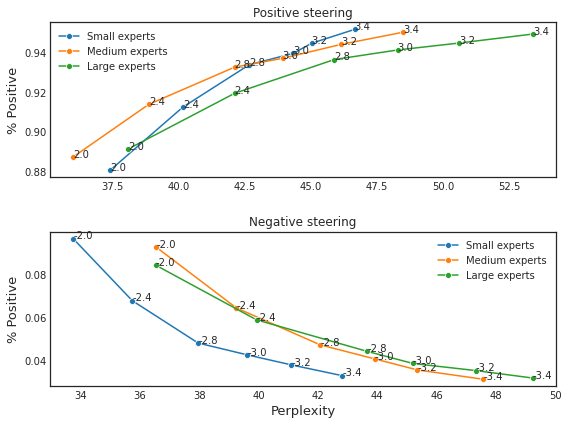

In [30]:
plt.figure()
fig, axes = plt.subplots(2, 1, figsize=(8,6))
plt.style.use('seaborn-white')
fig.tight_layout()

plot(small_res_df, label='Small experts', axes=axes)
plot(medium_res_df, label='Medium experts', axes=axes)
plot(large_res_df, label='Large experts', axes=axes)

ax = axes[0]
ax.set_xlabel(' ')
ax.set_ylabel('% Positive', fontsize=13)
ax.set_title('Positive steering')
ax.legend()

ax = axes[1]
ax.set_xlabel('Perplexity', fontsize=13)
ax.set_ylabel('% Positive', fontsize=13)
ax.set_title('Negative steering')

plt.tight_layout()
plt.savefig('figures/sentiment_v_perplexity.png')